### Find inverse traces
This notebook shows now to predict inverse trace using first break piking model and Random Trees.

### Task description
Some traces may be inversed because of the sensor failure. Using first break piking model and some features from traces we train RandomForest to solve the problem.

### Generated dataset discription
Let's have a look on the features that will be used for inverse traces detection. The dataset consist the following params:
* the amplitude value at the point of the first break picking
* offset
* the difference between amplitude value on the N traces of neighors
* the difference between time value of the first break picking on the N traces of neighbors
* correlation between part of traces with first break picking points.

In [1]:
import sys
import torch
import segyio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

sys.path.append('../..')

from seismicpro.batchflow import Pipeline, Dataset, B
from seismicpro.batchflow.models.torch import TorchModel
from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex, 
                            merge_picking_files, seismic_plot, KNNIndex)
from inverse_batch import InverseBatch

### Data

Firstly have a look on the data. Let's draw some of traces and try to guess the inverse trace.

In [2]:
path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'

index = (FieldIndex(name='raw', path=path_raw, extra_headers=['offset']))

batch = (Dataset(index, InverseBatch).p
         .load(components='raw', fmt='segy')
         ).next_batch(1)
field = batch.raw[0]
mask = np.ones(len(field))
ix = np.random.choice(len(mask))
mask[ix] = -1
inv_field = np.array([trace * mask[i] for i, trace in enumerate(field)])

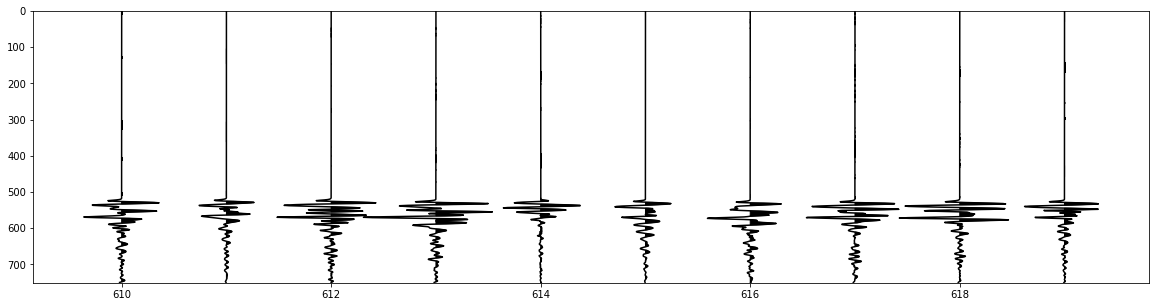

In [3]:
left = np.random.randint(0, 10)
right = 10 - left
seismic_plot(inv_field, cmap='gray', wiggle=True, vmax=.1, cmin=-0.1,
             figsize=(20, 5), std=0.1, xlim=(ix-left, ix+right))

In [4]:
print('Inverse trace is {}.'.format(ix))

Inverse trace is 614.


### Preprocessing

Firstly we load pretrained first break piking model.

In [5]:
model_path = '/notebooks/kalashnikov/geolog/models/First_break_picking/picks_modelUNet_ker5.dill'

model_ppl = Pipeline().init_model('dynamic', TorchModel, 'my_model',
                            config={'load' : {'path' : model_path},
                                    'build': False})

model = model_ppl.get_model_by_name('my_model').model

Define pipeline and generate the dataset.

In [6]:
N_NEIGH = 5
SIZE = 30

def f(a):
    return (a - a.mean())/a.std()

ppl = (Dataset(index, InverseBatch).p
         .load(components='raw', fmt='segy')
         .init_variable('diff', init_on_each_run=list)
         .apply_transform(f, src='raw')
         .generate_inverse_dataset(model, num_neig=N_NEIGH, src='raw', size=SIZE, dst='diff')
         .update_variable('diff', B('diff'), mode='e')
        )

Split dataset on train and test.

In [7]:
%%time
z = ppl.next_batch(15)

diff = ppl.get_variable('diff')
data = np.concatenate(diff)

np.random.shuffle(data)
dataset, target = data[:,:-1], data[:,-1]
dataset = np.nan_to_num(dataset)

X_train, X_test, y_train, y_test = train_test_split(dataset, target)

CPU times: user 11min 37s, sys: 2min 34s, total: 14min 12s
Wall time: 6min 54s


Have a look on the dataset.

In [8]:
gen_name = lambda name, n: [name + '_{}'.format(i) for i in range(n)]
columns = ['amplitude', 'offset', *gen_name('amp_left', N_NEIGH), *gen_name('inv_amp_left', N_NEIGH),
           *gen_name('amp_right', N_NEIGH), *gen_name('inv_amp_right', N_NEIGH),
           *gen_name('diff_pred_left', N_NEIGH), *gen_name('inv_diff_pred_left', N_NEIGH),
           *gen_name('diff_pred_right', N_NEIGH), *gen_name('inv_diff_pred_right', N_NEIGH),
           *gen_name('corr_left', N_NEIGH), *gen_name('corr_right', N_NEIGH), 
           *gen_name('inv_corr_left', N_NEIGH), *gen_name('inv_corr_right', N_NEIGH)]
df = pd.DataFrame(X_train, columns=columns)
print('Dataset shape is: {}\n'.format(df.shape))
df.head()

Dataset shape is: (18850, 62)



,amplitude,offset,amp_left_0,amp_left_1,amp_left_2,amp_left_3,amp_left_4,inv_amp_left_0,inv_amp_left_1,inv_amp_left_2,...,inv_corr_left_0,inv_corr_left_1,inv_corr_left_2,inv_corr_left_3,inv_corr_left_4,inv_corr_right_0,inv_corr_right_1,inv_corr_right_2,inv_corr_right_3,inv_corr_right_4
0,3.522338,925.0,2.340854,-3.958946,-3.077325,1.187726,0.307349,1.149771,-13.490530,1.183028,...,0.524774,0.742097,-0.486301,-0.697677,0.900664,-0.682704,0.576182,-0.477901,0.736847,-0.735615
1,0.773104,1881.0,-0.890950,-2.232126,-2.017457,-1.536269,-2.115565,0.292675,-0.115155,-0.098059,...,0.666411,0.982541,0.959863,0.174679,0.954181,0.956478,0.930090,0.984253,0.952178,0.947878
2,4.073972,1963.0,1.497549,1.155178,1.576524,2.079777,2.082404,0.060452,0.804619,0.581321,...,0.848837,0.575073,0.686797,0.918910,0.779391,0.912957,0.965720,-0.098989,0.242850,0.488757
3,1.299199,1647.0,-4.934522,-2.900895,-3.655272,-2.633507,-1.645020,-1.274118,-0.600839,-0.749659,...,0.786309,0.736165,0.773819,0.816472,0.938315,0.933593,0.946077,0.854174,0.703394,0.978576
4,1.223604,1755.0,-3.154365,-1.688227,-2.355326,-3.780530,-2.598222,-0.454963,-0.128009,0.014868,...,0.978953,0.946185,0.947300,0.811646,0.970812,0.846612,0.847501,-0.304358,-0.015499,0.923829


### Train Model
Using dataset generated above let's train Random Forest alghoritm.

In [9]:
tree = RandomForestClassifier()
tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Now let's check the model quality. 

In [10]:
pred = tree.predict(X_test)
print(classification_report(y_test, pred))
print('Accuracy score: {:.3}'.format(accuracy_score(y_test, pred)))

             precision    recall  f1-score   support

        0.0       0.91      0.94      0.93      3151
        1.0       0.94      0.91      0.92      3133

avg / total       0.93      0.93      0.93      6284

Accuracy score: 0.925


And graw feature importance.

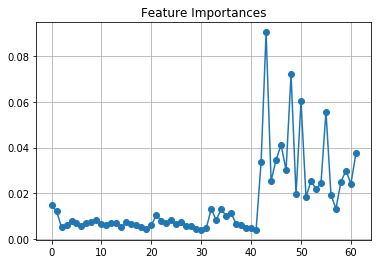

In [11]:
plt.title('Feature Importances')
plt.plot(range(len(tree.feature_importances_)), tree.feature_importances_, marker='o')
plt.grid()

### Predict on one field

Let's inverse some traces in one filed and check how the model will find inverse traces.

In [12]:
ppl = (Dataset(index, InverseBatch).p
         .load(components='raw', fmt='segy')
         .init_variable('diff', init_on_each_run=list)
         .apply_transform(f, src='raw')
         .generate_inverse_dataset(model, num_neig=N_NEIGH, src='raw', mode='predict', size=SIZE, dst='diff')
         .update_variable('diff', B('diff'), mode='e')
        )

In [13]:
batch = ppl.next_batch(1)

pred_diff = ppl.get_variable('diff')
pred_data = np.concatenate(pred_diff)

pred_dataset, pred_target = pred_data[:, : -1], pred_data[:, -1]
pred_dataset = np.nan_to_num(pred_dataset)

pred = tree.predict(pred_dataset)

In [14]:
print(classification_report(pred_target, pred))
print('Accuracy score: {:.3}'.format(accuracy_score(pred_target, pred)))
print('Number of inverse traces: {}'.format(sum(pred_target)))
print('Number of predict inverse traces: {}'.format(sum(pred)))
false_neg = sum(pred_target[np.where(pred_target != target)])
print('Number of missed inverse traces: {}'.format(false_neg))

             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99       837
        1.0       0.14      1.00      0.24         3

avg / total       1.00      0.98      0.99       840

Accuracy score: 0.977
Number of inverse traces: 3.0
Number of predict inverse traces: 22.0
Number of missed inverse traces: 0.0


One can notice that there are many false positive predictions and zero false negative.